Step 1: Library imports 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedShuffleSplit
from sklearn.linear_model import LinearRegression, Lasso, SGDRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings("ignore")

**STEP 2: LOAD AND COMBINE DATA**

In [2]:
train = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')


**EDA**

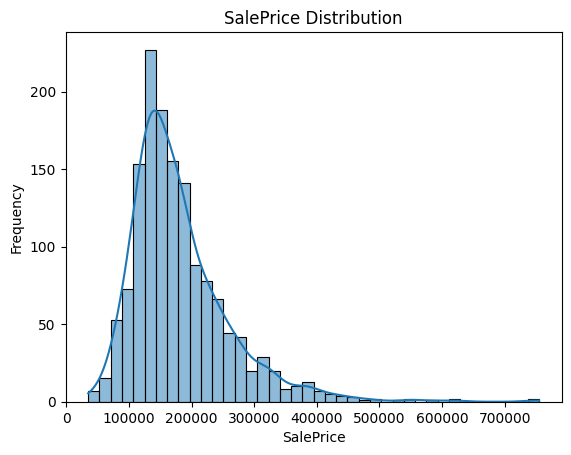

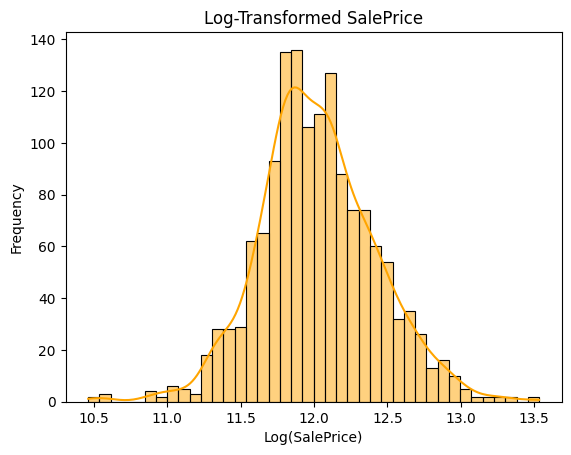

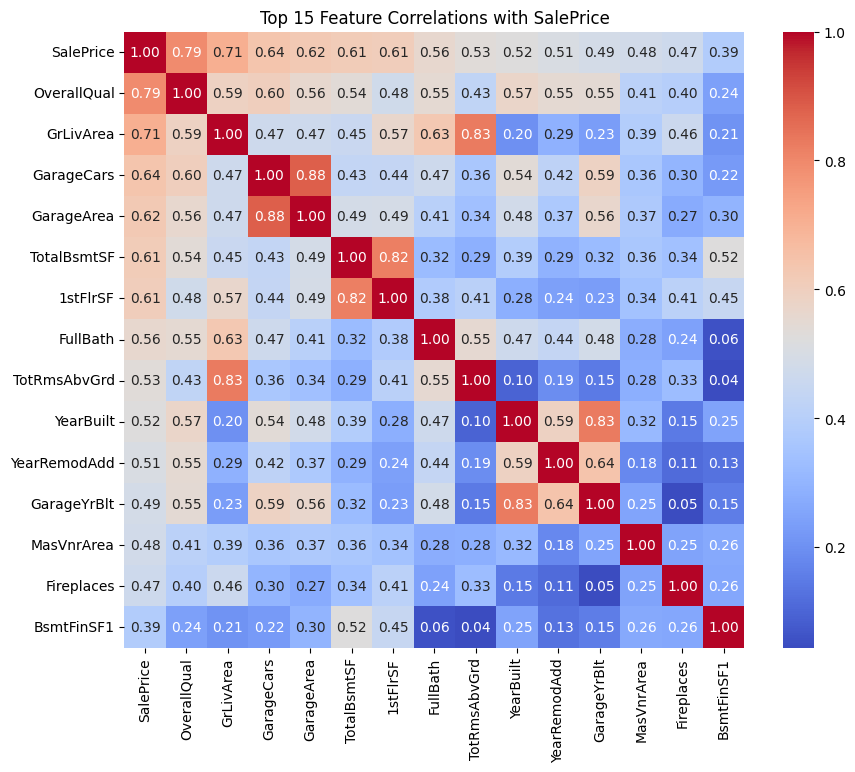

In [3]:
sns.histplot(train['SalePrice'], kde=True, bins=40)
plt.title('SalePrice Distribution')
plt.xlabel('SalePrice')
plt.ylabel('Frequency')
plt.show()

# Log-transformed SalePrice
sns.histplot(np.log1p(train['SalePrice']), kde=True, bins=40, color='orange')
plt.title('Log-Transformed SalePrice')
plt.xlabel('Log(SalePrice)')
plt.ylabel('Frequency')
plt.show()

# -----------------------------------------
# Correlation Heatmap (Top 15 features)
# -----------------------------------------
corr = train.corr(numeric_only=True) #prints pairwise pearson correlation 
top_corr_features = corr['SalePrice'].abs().sort_values(ascending=False).head(15).index

plt.figure(figsize=(10, 8))
sns.heatmap(train[top_corr_features].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Top 15 Feature Correlations with SalePrice')
plt.show()

In [4]:
train.head()
print(train.columns.tolist())
#train = train[top_corr_features]

['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC'

In [5]:
train['TrainFlag'] = 1
test['TrainFlag'] = 0
test['SalePrice'] = np.nan

data = pd.concat([train, test], axis=0, ignore_index=True)
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,TrainFlag
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0,1
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0,1
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0,1
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0,1
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0,1


**STEP 3: FEATURE ENGINEERING**

In [6]:
data['TotalSF'] = data['TotalBsmtSF'] + data['1stFlrSF'] + data['2ndFlrSF'] #calculates total square footage of residency 
data['TotalBathrooms'] = (data['FullBath'] + 0.5 * data['HalfBath'] + data['BsmtFullBath'] + 0.5 * data['BsmtHalfBath']) #arbitrary calculation of total # of bathrooms
data['HasPool'] = data['PoolArea'].apply(lambda x: 1 if x > 0 else 0) #check if house has pool 
data['IsRemodeled'] = (data['YearBuilt'] != data['YearRemodAdd']).astype(int) #check if house was remodelled 
data['HouseAge'] = data['YrSold'] - data['YearBuilt'] #total age
data['RemodAge'] = data['YrSold'] - data['YearRemodAdd'] #total remodel age
#data['TotalPorch'] = data['WoodDeckSF'] + data['OpenPorchSF'] + data['EnclosedPorch'] + data['3SsnPorch'] + data['ScreenPorch']
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,SaleType,SaleCondition,SalePrice,TrainFlag,TotalSF,TotalBathrooms,HasPool,IsRemodeled,HouseAge,RemodAge
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,WD,Normal,208500.0,1,2566.0,3.5,0,0,5,5
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,WD,Normal,181500.0,1,2524.0,2.5,0,0,31,31
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,WD,Normal,223500.0,1,2706.0,3.5,0,1,7,6
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,WD,Abnorml,140000.0,1,2473.0,2.0,0,1,91,36
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,WD,Normal,250000.0,1,3343.0,3.5,0,0,8,8


**REMOVING OUTLIERS**

In [7]:
#def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
#    quartile1 = dataframe[col_name].quantile(q1)
#    quartile3 = dataframe[col_name].quantile(q3)
#    interquantile_range = quartile3 - quartile1
#    up_limit = quartile3 + 1.5 * interquantile_range
#    low_limit = quartile1 - 1.5 * interquantile_range
#    return low_limit, up_limit

#for col in data.select_dtypes(include=['int64', 'float64']).columns:
#    low_iqr, up_iqr = outlier_thresholds(data, col)
#    outlier_data = data[col]
#    data[col] = data[(data[col] > low_iqr) & (data[col] < up_iqr)]

**STEP 4: HANDLE MISSING VALUES**

In [8]:
data.isnull().sum() #counts # of NaN for each column 

Id                  0
MSSubClass          0
MSZoning            4
LotFrontage       486
LotArea             0
                 ... 
TotalBathrooms      2
HasPool             0
IsRemodeled         0
HouseAge            0
RemodAge            0
Length: 88, dtype: int64

In [9]:
for col in data.select_dtypes(include='object').columns:
    data[col] = data[col].fillna('None')

for col in data.select_dtypes(include=['int64', 'float64']).columns:
    data[col] = data[col].fillna(data[col].median())

**STEP 5: LABEL ENCODING**

In [10]:
for col in data.select_dtypes(include='object').columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col]) #lets say it was house colour and there was (red, black, white)
    # LabelEncoder() would determine the # of labels and encode some int value to each of the labels 

In [11]:
#data.head()
print(data['Neighborhood'])

0        5
1       24
2        5
3        6
4       15
        ..
2914    10
2915    10
2916    11
2917    11
2918    11
Name: Neighborhood, Length: 2919, dtype: int64


**STEP 6: SPLIT TRAIN AND TEST BACK**

In [12]:
train_cleaned = data[data['TrainFlag'] == 1].drop('TrainFlag', axis=1)
test_cleaned = data[data['TrainFlag'] == 0].drop(['TrainFlag', 'SalePrice'], axis=1)
#drop price since we're trying to determine the sale price 

X = train_cleaned.drop(['Id', 'SalePrice'], axis=1) #data
y = np.log1p(train_cleaned['SalePrice'])  # log1p, log scale of the sale price of training set 
X_test_final = test_cleaned.drop('Id', axis=1)

**Scaling (only feature matrix, not target)**

In [13]:
#scaler = StandardScaler()
#for col in data.select_dtypes(include=['int64', 'float64']).columns:
#    train_cleaned = scaler.fit_transform(train_cleaned[col])

**STEP 7: SPLIT TRAIN-VALIDATION FOR LOCAL TEST**

In [14]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

**STEP 8: TRAIN DEFAULT REGRESSION MODELS**

In [15]:
def train_and_evaluate(model, name):
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    rmse = np.sqrt(mean_squared_error(y_valid, preds))
    r2 = r2_score(y_valid, preds)
    mae = mean_absolute_error(y_valid, preds)
    print(f"{name} RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")
    return (name, model, rmse, mae, r2)

def grid_search_model(model, param_grid, name):
    grid_model = GridSearchCV(model, param_grid, cv = 5, n_jobs = -1)
    grid_model.fit(X_train, y_train)
    final_model = grid_model.best_estimator_.fit(X_train, y_train)

    #test set
    test_pred = final_model.predict(X_valid)
    rmse = np.sqrt(mean_squared_error(y_valid, test_pred))
    r2 = r2_score(y_valid, test_pred)
    mae = mean_squared_error(y_true=y_valid, y_pred=test_pred)

    print(f"{name} RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")
    return (name, model, rmse, mae, r2)
    
param_grid = {'max_depth': [2, 3, 4],
              'eta': [0.01, 0.1],
              'subsample': [0.3, 0.4, 0.5, 0.6, 0.7],
              'colsample_bytree': [0.9, 1.0]}

results = []
results.append(train_and_evaluate(LinearRegression(), "Linear Regression"))
results.append(train_and_evaluate(Lasso(alpha=0.001), "Lasso Regression"))
results.append(train_and_evaluate(SVR(C=1.0, kernel='rbf'), "Support Vector Regression"))
results.append(train_and_evaluate(RandomForestRegressor(n_estimators=200, random_state=42), "Random Forest"))
results.append(train_and_evaluate(XGBRegressor(n_estimators=1000, learning_rate=0.05, max_depth=6, random_state=42, alpha=1), "XGBoost"))
results.append(grid_search_model(model=XGBRegressor(), param_grid=param_grid, name="XGBoost + Grid Search"))

#results.append(train_and_evaluate(SGDRegressor(max_iter=1000, eta0=0.1, learning_rate='constant', random_state=42), "SGD Regression"))
# SGD prob does really bad because dataset is large, lots of indep varaibles, and not all integer values 


Linear Regression RMSE: 0.1521, MAE: 0.0997, R²: 0.8636
Lasso Regression RMSE: 0.1472, MAE: 0.1043, R²: 0.8723
Support Vector Regression RMSE: 0.1987, MAE: 0.1422, R²: 0.7673
Random Forest RMSE: 0.1313, MAE: 0.0876, R²: 0.8984
XGBoost RMSE: 0.1318, MAE: 0.0861, R²: 0.8976
XGBoost + Grid Search RMSE: 0.1231, MAE: 0.0152, R²: 0.9107


In [16]:
results_df = pd.DataFrame(results, columns=["Model", "Instance", "RMSE", "MAE", "R2"])
print(results_df)
print("\nRegression Models Comparison:\n", results_df.sort_values(by="RMSE")[["Model", "RMSE", "MAE", "R2"]])

                       Model  \
0          Linear Regression   
1           Lasso Regression   
2  Support Vector Regression   
3              Random Forest   
4                    XGBoost   
5      XGBoost + Grid Search   

                                            Instance      RMSE       MAE  \
0                                 LinearRegression()  0.152094  0.099748   
1                                 Lasso(alpha=0.001)  0.147206  0.104328   
2                                              SVR()  0.198681  0.142189   
3  (DecisionTreeRegressor(max_features=1.0, rando...  0.131297  0.087610   
4  XGBRegressor(alpha=1, base_score=None, booster...  0.131821  0.086095   
5  XGBRegressor(base_score=None, booster=None, ca...  0.123097  0.015153   

         R2  
0  0.863641  
1  0.872264  
2  0.767313  
3  0.898383  
4  0.897570  
5  0.910679  

Regression Models Comparison:
                        Model      RMSE       MAE        R2
5      XGBoost + Grid Search  0.123097  0.015153  0.9

In [17]:
# Sort untuned results by RMSE (lower is better)
best_untuned_row = results_df.sort_values(by="RMSE").iloc[0]
print("\nBest Untuned Model:")
print(f"Model: {best_untuned_row['Model']}")
print(f"RMSE: {best_untuned_row['RMSE']:.4f}")
print(f"MAE:  {best_untuned_row['MAE']:.4f}")
print(f"R²:   {best_untuned_row['R2']:.4f}")


Best Untuned Model:
Model: XGBoost + Grid Search
RMSE: 0.1231
MAE:  0.0152
R²:   0.9107


**STEP 9: BEST MODEL PREDICT**

In [18]:
results_df = pd.DataFrame(results, columns=["Model", "Instance", "RMSE", "MAE", "R2"])
best_untuned = results_df.sort_values("RMSE").iloc[0]["Instance"]

best_untuned.fit(X, y)
untuned_preds = np.expm1(best_untuned.predict(X_test_final))


In [19]:
submission_untuned = pd.DataFrame({
    'Id': test['Id'],
    'SalePrice': untuned_preds.astype(float)
})
submission_untuned.to_csv('submission.csv', index=False)
print("submission.csv saved.")

submission.csv saved.


In [20]:
sub = pd.read_csv('/kaggle/working/submission.csv')
sub.head()

,Id,SalePrice
0,1461,125882.789062
1,1462,182632.250000
2,1463,187460.500000
3,1464,194128.171875
4,1465,174080.671875
